In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

from classes.experiment import Experiment
from classes.agent import Agent

from methods.states_params_importer import import_states_params_asdict
from methods.action_plans import fetch_action_plan, generate_action_plan

%matplotlib inline

In [2]:
## Import behavioural experiment
with open('/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/data/global_modelling_data.obj', 'rb') as inFile:
    modelling_data = pickle.load(inFile)

print(len(modelling_data.keys()))

models_dict = import_states_params_asdict()


420


In [3]:
models_dict['actions']['tree_search_hard_horizon']['params']['args']

['obs',
 0.01,
 array([-100,  -50,    0,   50,  100]),
 1,
 (<function methods.policies.epsilon_greedy_init.<locals>.e_greedy_policy(action_values)>,
  <function methods.policies.epsilon_greedy_init.<locals>.pmf_e_greedy_policy(action_taken, action_values)>,
  <function methods.policies.epsilon_greedy_init.<locals>.params_e_greedy_policy(action_values)>),
 5,
 'posterior_unweighted',
 'expected_information_gained',
 1]

In [4]:
"""
Key parameters
"""

"""
Specifies whether loaded data will be used or not
fit_or_run == True: use loaded data

if true, it will treat all states as realised and will provide the posterior judgment and parameters of the specified agent

More granular options exist below to use parts of the existing data, e.g. actions, but let the rest be generated online
"""
fit_or_run = False # If false, no data will be used 

""" 
Modifies default parameters:

External states
Strength/rigidity - default is 0.5
"""

rigidity = 0.5
models_dict['external']['OU_Network']['params']['kwargs']['theta'] = rigidity
#models_dict['internal']['normative']['params']['args'][-2] = rigidity
#models_dict['internal']['normative']['params']['args'][0] = rigidity

""" 
Variance/noise - default is 3
"""
sigma = 3
models_dict['external']['OU_Network']['params']['kwargs']['sigma'] = sigma
#models_dict['internal']['normative']['params']['args'][-1] = 15*sigma
#models_dict['internal']['LC_discrete_att']['params']['args'][-2] = 6*sigma

""" 
Actives states

Hard horizon tree search
Horizon (tree depth):
"""
#models_dict['actions']['tree_search_hard_horizon']['params']['args'][-1] = 2

""" 
Utility function
information gained or resource rational
"""
#models_dict['actions']['tree_search_hard_horizon']['params']['args'][-2] = 'resource_rational'#'expected_information_gained'
#models_dict['actions']['tree_search_hard_horizon']['params']['kwargs']['resource_rational_parameter'] = 1

' \nUtility function\ninformation gained or resource rational\n'

In [5]:

""" 
Loads data using the part_key variable which links to behavioural data
"""

part_key = '5ecd84fc5216e60fe17dd26a'
conditions = ['generic_0', 'generic_1', 'generic_2', 'congruent', 'incongruent', 'implausible']
cond = conditions[2]

part_data = modelling_data[part_key]
part_experiment = part_data['experiment']
trials = part_data['trials']

trial_data = trials[cond]
## Data from trial
model_name = trial_data['name'][:-2]
difficulty = cond
data = trial_data['data'] # Raw numerical data of variable values
ground_truth = trial_data['ground_truth'] # Ground truth model from which data has been generated
ground_truth = np.array([1, 1, 0, 0, 0, 0])
#ground_truth = np.array([-1, 0.5, 0, 0, -1, 0])
#ground_truth = np.array([0, 0, -1, 0, 0, -1])

# Unpack generic trial relevant parameters
N = data.shape[0] - 250 # Number of datapoints
#N = 150
K = data.shape[1] # Number of variable

inters = trial_data['inters'] # Interventions as is
inters_fit = trial_data['inters_fit'] # Interventions with removed movements
judgement_data = trial_data['links_hist'] # Change in judgement sliders
posterior_judgement = trial_data['posterior'] # Final states of judgement sliders
prior_judgement = trial_data['prior'] if 'prior' in trial_data.keys() else None
utid = trial_data['utid']

In [6]:
"""
Set up agent states and fitting options
"""

"""
Choose whether to use fitted parameters or default ones
"""
use_fitted_parameters = False


"""
Construct agents by choosing its states

1. Internal states
2. Sensory states
3. Active states
"""

internal_states_list = [
    'normative_&_1',
    #'LC_discrete_&_1',
    #'LC_discrete_att_&_att',
    #'change_obs_fk_&_att_cha',
    #'mean_field_vis'
]
sensory_states_list = [
    'omniscient'
]
action_states_list = [
    #'experience_vao',
    #'tree_search_soft_horizon',
    'tree_search_hard_horizon'
]

"""
Choose the agent's behaviour

behaviour specifies how the agent acts: 
    - actor (str): acts according to the action state 
    - random (str): random actions
    - obs (str): only observes, takes no actions (useful for generating sample paths without inference)

use_action_plan specifies a predefined action set and will override the behaviour variable if not set to None
Action plans can be added by amended in the ./methods/action_plan.py file, current ones include:
    - None (bool): default, the agent will behave according to the behaviour variable
    - data (str): will make an action plan out of the preloaded data if available (participant or saved model data)  
    - [0, 1] (float): will generate an action plan where the agent intervenes the proportion of time given by the argument with swipes from 90 to -90
    - mid_single_swipe__90__1/3 (str): will perform a single swipe at 90 on one variable for 1/3 of the time in the middle of a trial
    - double_swipe__90__1/6: single swipe at 1/3 and another at 2/3
    - bespoke (str): see options in the action_plans.py file in the fetch_action_plan function, add an elif statement with the name of the action plan and its specification to add new options
"""
behaviour = 'actor' # Can be random, obs, or actor
use_action_plan = None#'data'


"""
Detailed online report of agents beliefs
(No impact on behaviour)
"""
verbose = True

"""
Options for data generation and bespoke sample paths

Use this options for simulating data but are not interested in the inference process
Set bespoke_experiment to False for standard paths with inference
"""
bespoke_experiment = False

if bespoke_experiment:
    ground_truth = np.array([1, 0, 0, 1, 0, 0])
    #ground_truth = np.array([1, 1, 0, 1, 0, 0])
    #ground_truth = np.array([1, -1, 0, 1, 0, 0])

    N = data.shape[0] - 0 # Number of datapoints
    N = 100

    rigidity = 0.5
    models_dict['external']['OU_Network']['params']['args'][0] = rigidity

    internal_states_list = ['LC_discrete_&_1'] # Fastest 
    #use_action_plan = 'mid_single_swipe__80__1/6' # Will override the previous definition of the varialbe
    #use_action_plan = 'double_swipe__90__1/6'
    use_action_plan = None
    init_state = np.array([-60, 0, 0])

    vebose = False


In [7]:
"""
Set up all state given above specified parametrisation
DO NOT AMEND THIS CELL
"""

# Apply fitted parameter option
if use_fitted_parameters:
    with open('./data/params_fitting_outputs/fitted_params.json', 'r') as infile:
        use_fitted_params = json.load(infile)
else:
    use_fitted_params = False

if use_fitted_params:
    fitted_params_dict = use_fitted_params[part_key] 

# Apply action plan option
if use_action_plan:
    if isinstance(use_action_plan, float):
        action_plan = generate_action_plan(N, K, time=use_action_plan)
    elif use_action_plan == 'data':
        action_plan = [trial_data['inters'], trial_data['data']]
    elif isinstance(use_action_plan, str):
        action_plan = fetch_action_plan(use_action_plan, N, K)
    acting_len = (1 - np.isnan(action_plan[0])).mean()
else:
    action_plan = None

# Set up external state: OU netowrk 
external_state = models_dict['external']['OU_Network']['object'](N, K, 
                                                                 *models_dict['external']['OU_Network']['params']['args'],
                                                                 **models_dict['external']['OU_Network']['params']['kwargs'], 
                                                                 ground_truth=ground_truth)

if fit_or_run == 'fit':
    external_state.load_trial_data(data) # Load Data

# Apply bespoke experiment 
if bespoke_experiment:
    external_state.reset(init_state=init_state)

# Set up states
## Internal states and sensory states
internal_states = []
sensory_states = []
for i, model_tags in enumerate(internal_states_list):
    if len(model_tags.split('_&_')) == 2:
        model, tags = model_tags.split('_&_')
    else:
        model = model_tags.split('_&_')[0]

    ## Internal States
    internal_states_kwargs = models_dict['internal'][model]['params']['kwargs'].copy()
    ## Sensory States
    sensory_states_kwargs = models_dict['sensory'][sensory_states_list[i]]['params']['kwargs'].copy()
    # Setup fitted params
    if use_fitted_params and model_tags in fitted_params_dict.keys():
        for param_key, param_val in fitted_params_dict[model_tags].items():
            # Internal states params
            if param_key in internal_states_kwargs.keys():
                internal_states_kwargs[param_key] = param_val
            # Sensory states params
            if param_key in sensory_states_kwargs.keys():
                sensory_states_kwargs[param_key] = param_val

    # Set up internal states
    i_s = models_dict['internal'][model]['object'](N, K, 
                                                   *models_dict['internal'][model]['params']['args'],
                                                   **internal_states_kwargs,
                                                   generate_sample_space = True)

    # Initialise prior distributions for all IS
    i_s.initialise_prior_distribution(prior_judgement)
    # Load data if fitting
    if fit_or_run == 'fit':
        i_s.load_judgement_data(judgement_data, posterior_judgement, False)
    
    internal_states.append(i_s)
        
    # Set up sensory states
    sensory_s = models_dict['sensory'][sensory_states_list[i]]['object'](N, K, 
                                                                         *models_dict['sensory'][sensory_states_list[i]]['params']['args'],
                                                                         **sensory_states_kwargs)
    sensory_states.append(sensory_s)

## Action states
action_states = []
for model in action_states_list:
    action_states_kwargs = models_dict['actions'][model]['params']['kwargs'].copy()
    if use_fitted_params and model in fitted_params_dict.keys():
        for param_key, param_val in fitted_params_dict[model].items():
            if param_key in action_states_kwargs.keys():
                action_states_kwargs[param_key] = param_val
    
    a_s = models_dict['actions'][model]['object'](N, K, 
                                                 *models_dict['actions'][model]['params']['args'],
                                                 **action_states_kwargs)
    # Load action data if fitting
    if fit_or_run == 'fit':
        a_s.load_action_data(inters, inters_fit, data)
    else:
        if action_plan:
            a_s.load_action_plan(*action_plan)
        else:
            # If no action plan, behaviour is given by the behaviour variable given in above cell
            a_s._behaviour = behaviour 

    action_states.append(a_s)

if len(action_states) == 1: # Can only be 1 atm, multiple action states are not supported
    action_states = action_states[0] 


# Create agent
if len(internal_states) == 1:
    agent = Agent(N, sensory_states[0], internal_states[0], action_states)
else:
    agent = Agent(N, sensory_states, internal_states, action_states)
# Create experiment
experiment = Experiment(agent, external_state)

In [8]:
"""
Run the experiment according to the specified parametrisation
DO NOT AMEND THIS CELL
"""

if fit_or_run == 'fit':
    experiment.fit(verbose=verbose)
else:
    experiment.run(verbose=verbose)

#experiment.entropy_report()

True model: [1. 1. 0. 0. 0. 0.]

 Realisation 1 out of 1: 

Iter: 0
Current MAP: [-1. -1. -1. -1. -1. -1.] Entropy: 13.931568569324174
Iter: 10
Current MAP: [1. 1. 0. 0. 0. 0.] Entropy: 3.4586484845983563
Iter: 20
Current MAP: [1. 1. 0. 0. 0. 0.] Entropy: 0.271247719173063
Iter: 30
Current MAP: [1. 1. 0. 0. 0. 0.] Entropy: 0.013254932460249155
Iter: 40
Current MAP: [1. 1. 0. 0. 0. 0.] Entropy: 0.0003712989425294507
Iter: 50
Current MAP: [1. 1. 0. 0. 0. 0.] Entropy: 0.00018835393018021588
Iter: 51
True model: [1. 1. 0. 0. 0. 0.] Final MAP: [1. 1. 0. 0. 0. 0.]


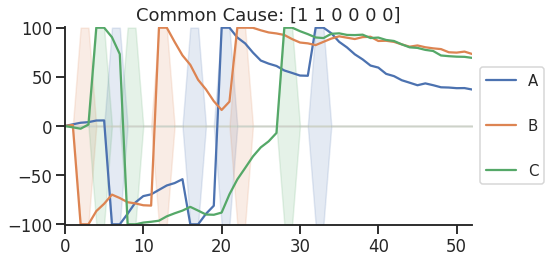

In [9]:
experiment.path_report(title=f'Common Cause: {ground_truth}', labels=['A', 'B', 'C'], savefig='simulation_common_cause_optimal_actor')

In [14]:
experiment.external_state._I

array([nan, nan,  2.,  2., nan, nan,  2.,  2., nan, nan,  1.,  1.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  2.,  2., nan,  0.,  0., nan, nan,
        1.,  1.,  1., nan, nan, nan, nan,  0.,  0., nan, nan, nan, nan,
        1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [15]:
experiment.external_state._X

array([[ -60.        ,    0.        ,    0.        ],
       [ -51.64104669,  -14.17322152,   -0.35058852],
       [ -47.07717822,  -30.12872609,  100.        ],
       [ -39.85390258,  -36.79736795,  100.        ],
       [ -37.07319507,  -41.06961097,   66.42141063],
       [ -37.24755052,  -45.76767595,   48.60414286],
       [ -31.33728574,  -49.93498924,  100.        ],
       [ -27.62314309,  -52.20736681,  100.        ],
       [ -24.80052567,  -51.7958861 ,   62.18814046],
       [ -20.66075974,  -51.66338151,   38.15098559],
       [ -19.67205203, -100.        ,   20.39354214],
       [ -18.65113276, -100.        ,   -7.5122321 ],
       [ -21.09522484,  -78.4195318 ,  100.        ],
       [ -22.13333599,  -68.47962441,  100.        ],
       [ -19.76448179,  -63.93294494,   50.        ],
       [ -17.02121986,  -59.38131682,   50.        ],
       [ -16.19009451,  -55.54212228,  100.        ],
       [ -11.29342272,  -52.4475566 ,  100.        ],
       [ -11.05701978,  -48.

<AxesSubplot:title={'center':'Update schedules: factors updated at each timepoint'}>

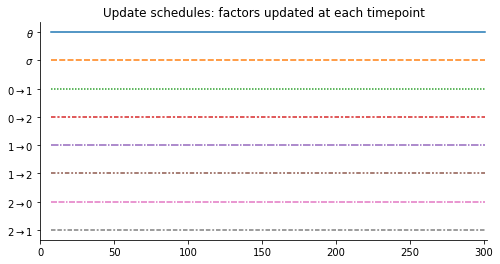

In [9]:
agent.plot_variational_schedules()

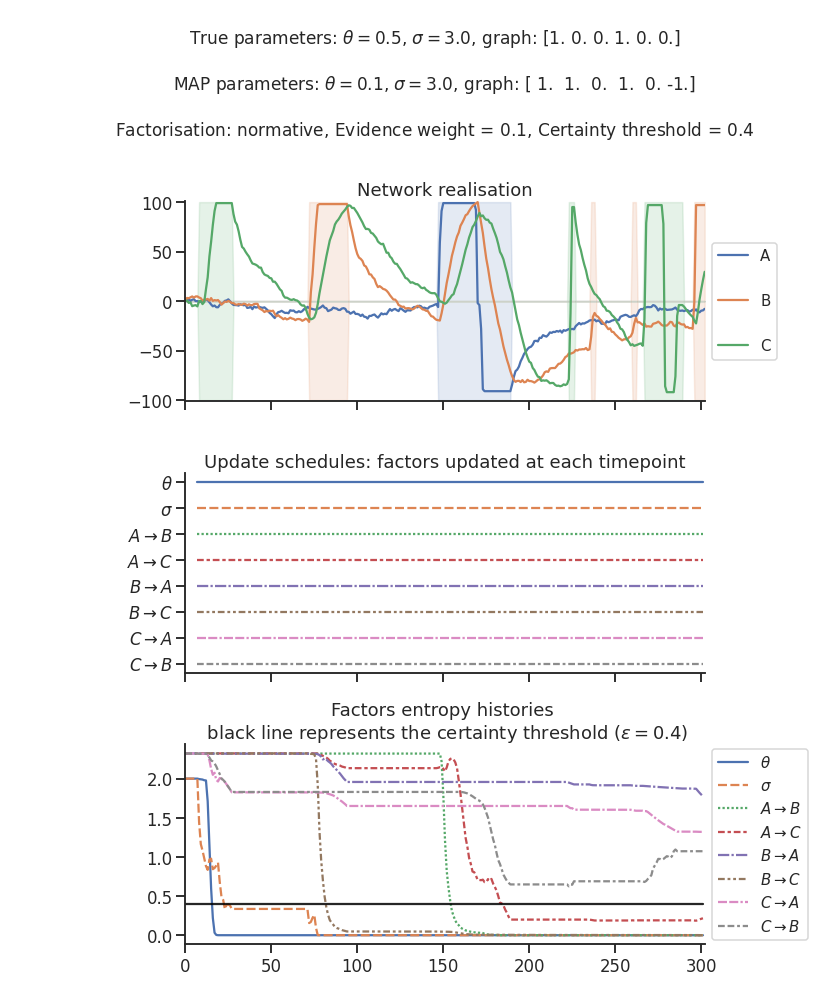

In [10]:
experiment.variational_report(labels=['A', 'B', 'C'])

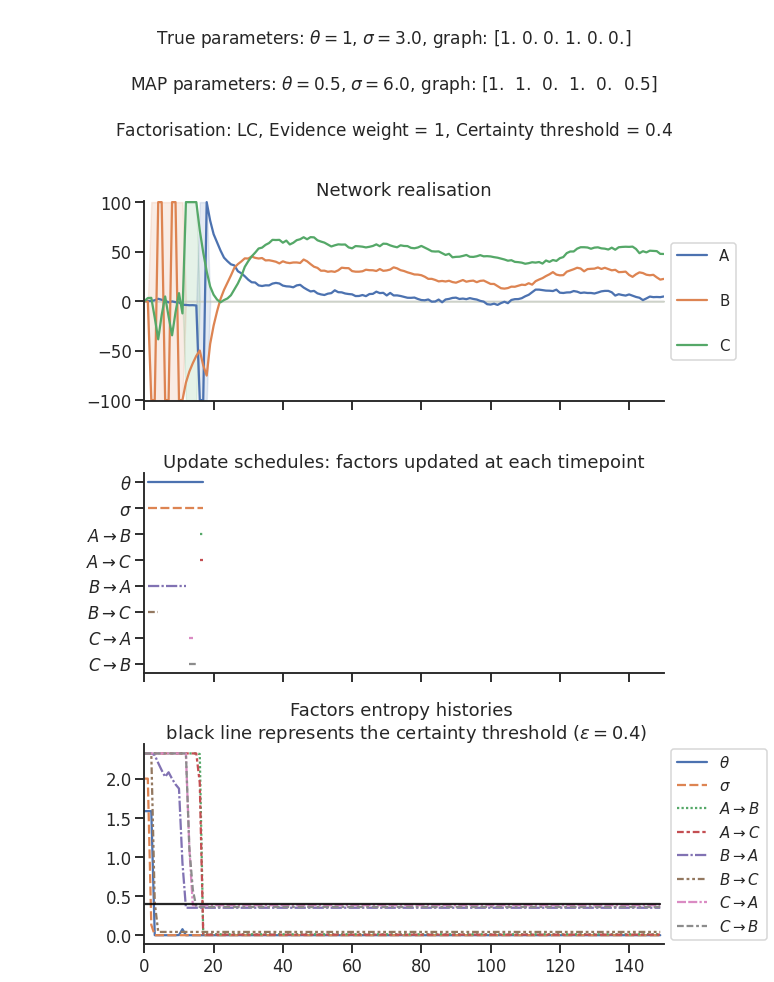

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

# Different rigidities

<AxesSubplot:title={'center':'$\\theta=1$'}>

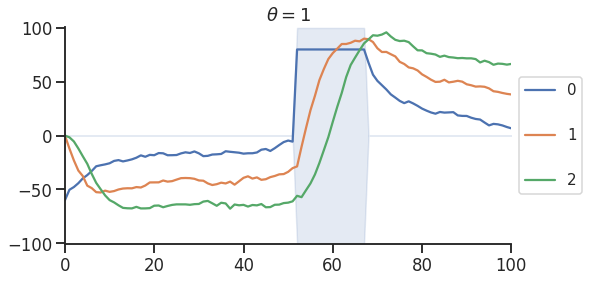

In [10]:
experiment.path_report(title='$\\theta=1$')

<AxesSubplot:title={'center':'$\\theta=0.1$'}>

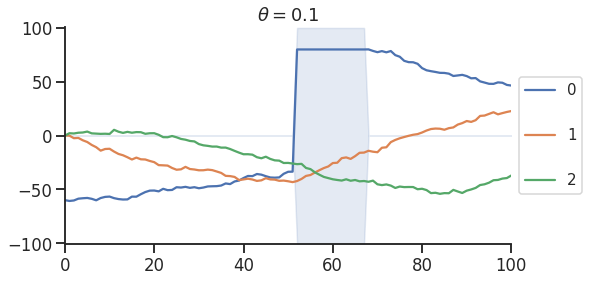

In [10]:
experiment.path_report(title='$\\theta=0.1$')

<AxesSubplot:title={'center':'$\\theta=0.5$'}>

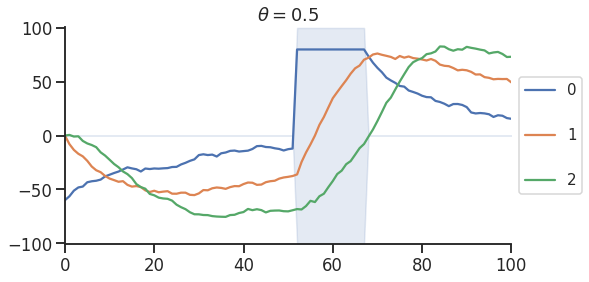

In [10]:
experiment.path_report(title='$\\theta=0.5$')

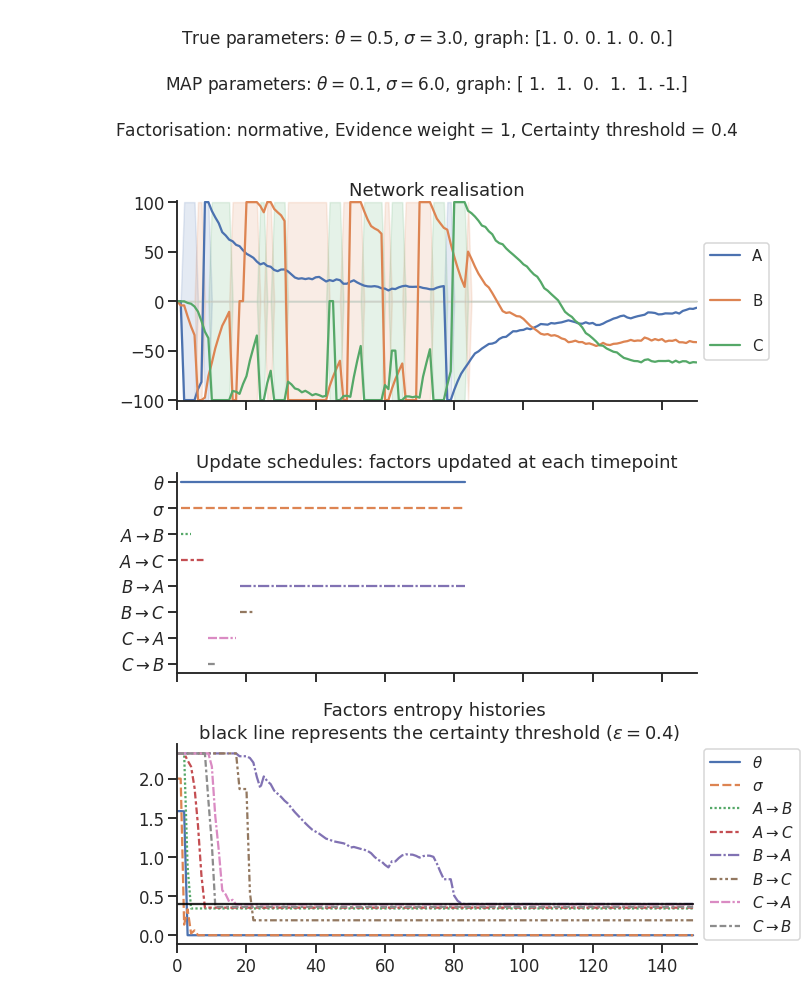

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

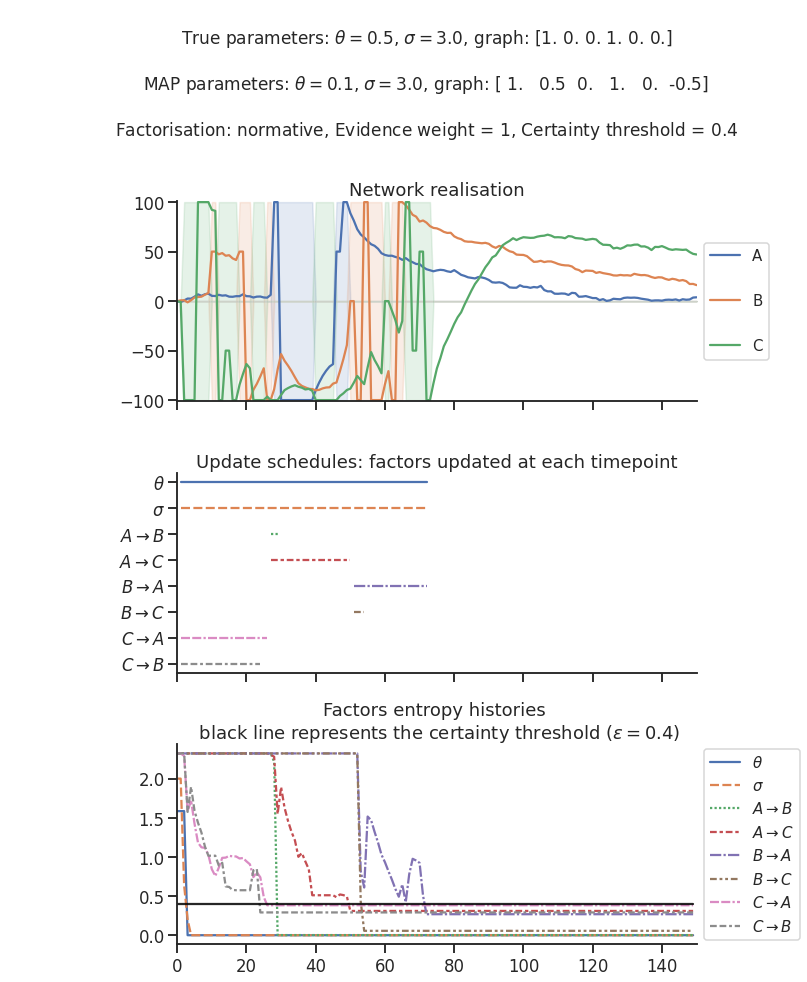

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

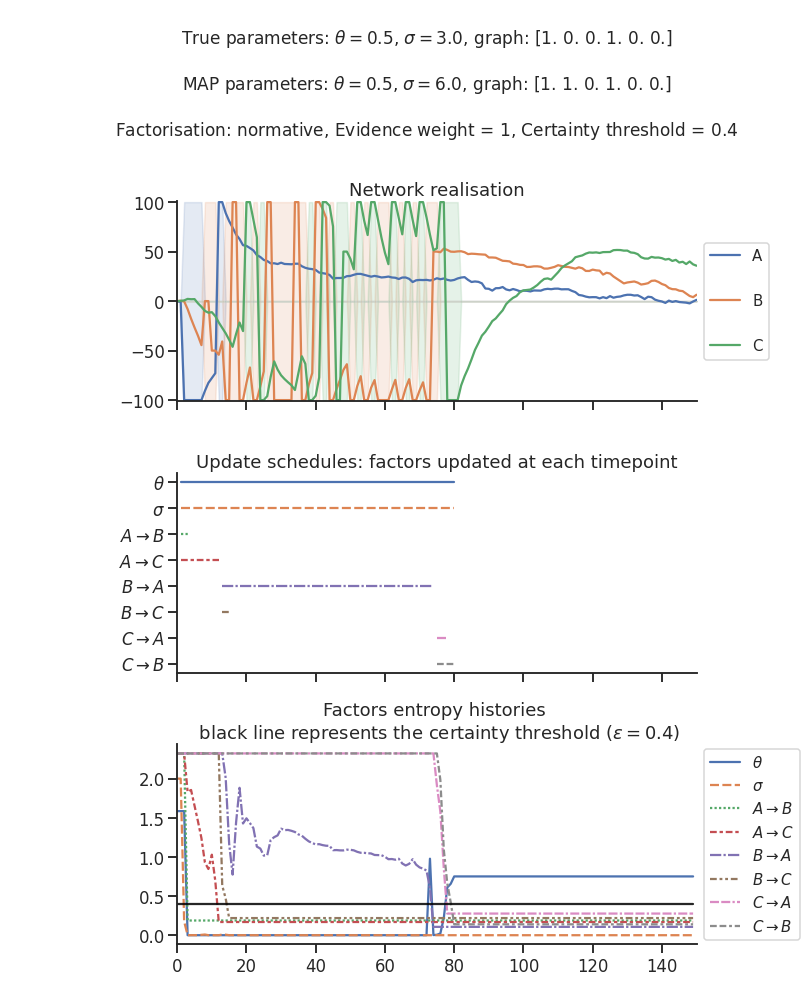

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

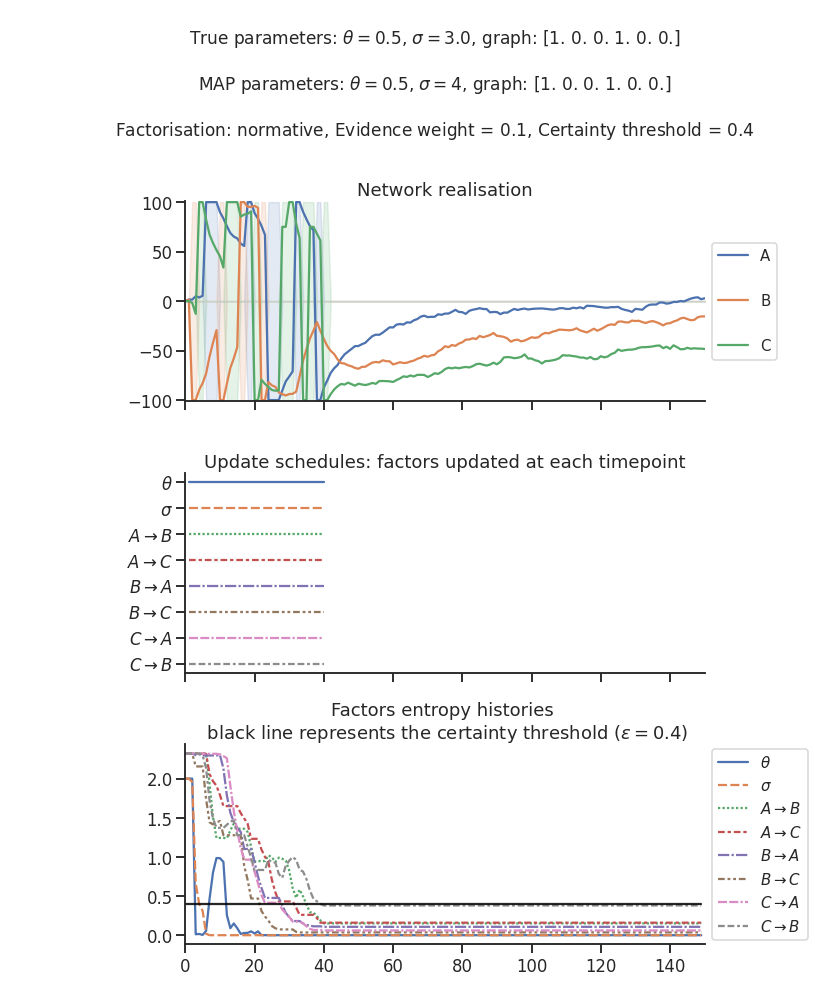

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

# Issue with undervaluing $\theta$ leading to chain bias

Hypersensitive to which values of $\theta$ are considered: 
- $\{0.1, 0.5, 1, 3\}$ is fine
- $\{0.1, 0.5, 1, 2\}$ problematic
- $\{0.1, 0.5, 1, 1.5\}$ is fine

Variable selection may be too deterministic in the single factor/single variable case but this cannot explain what happens in the full update case

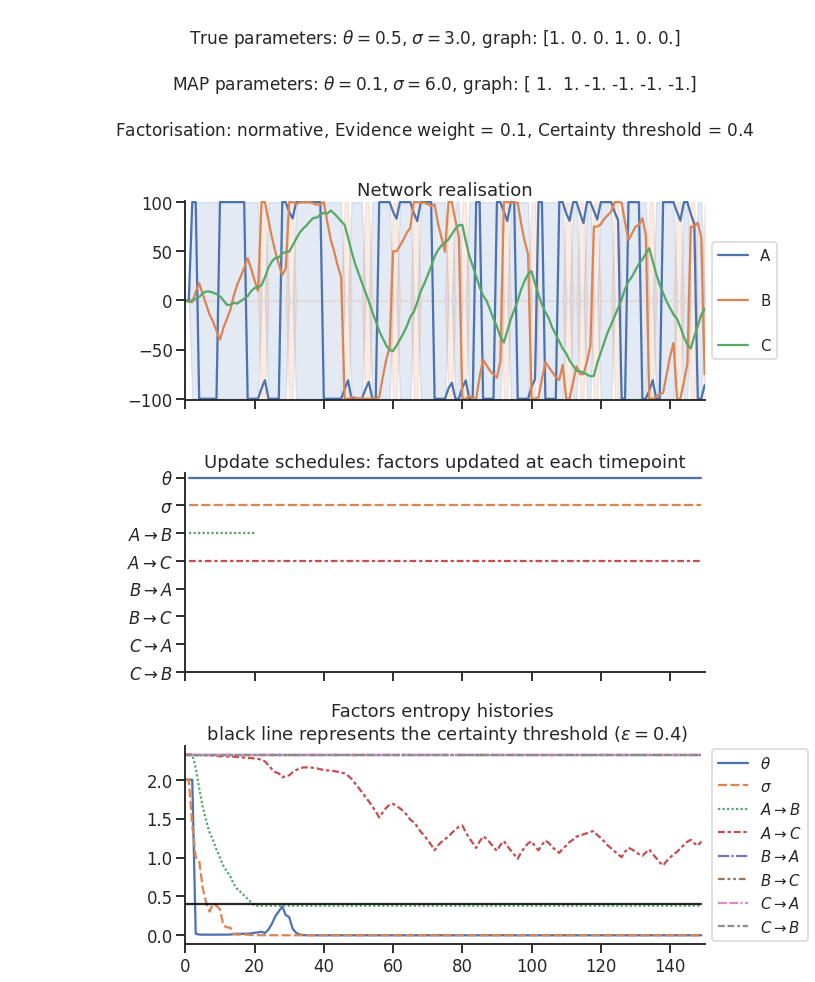

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

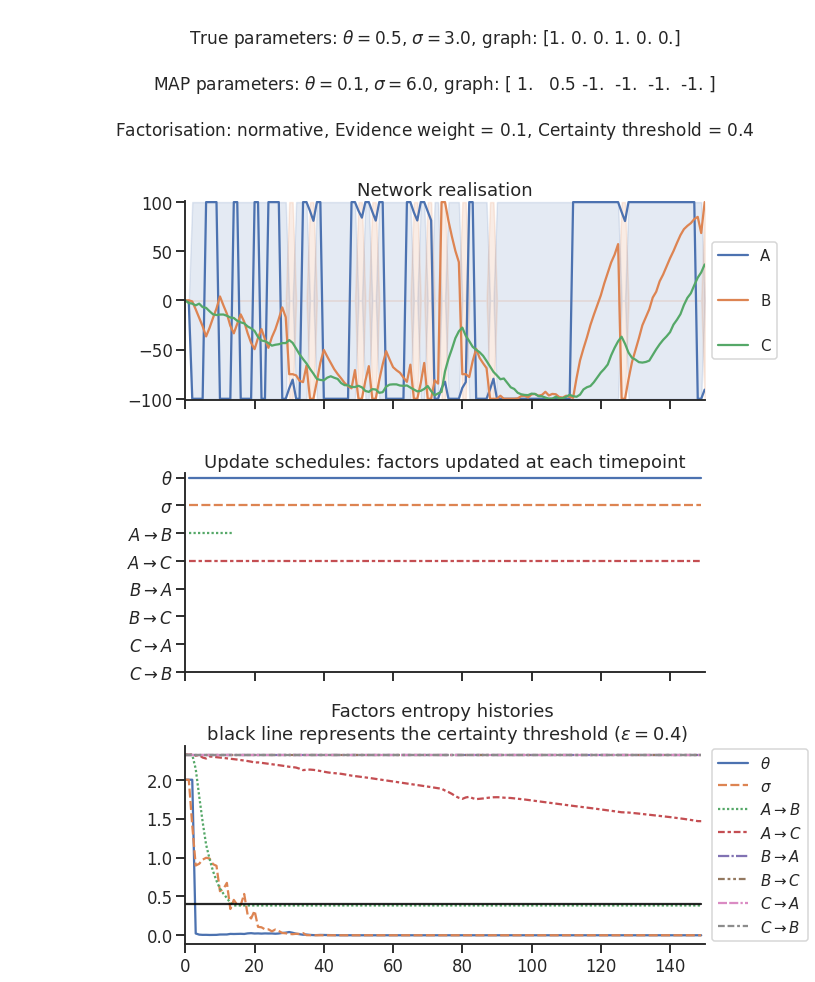

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

# Update schedule differences

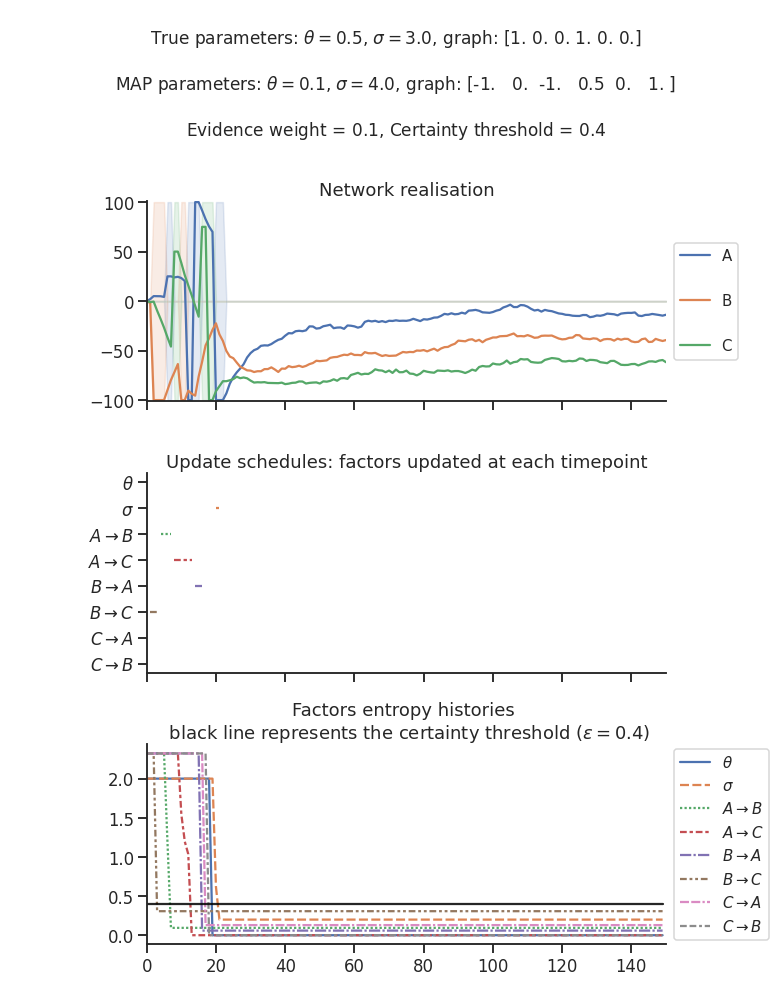

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

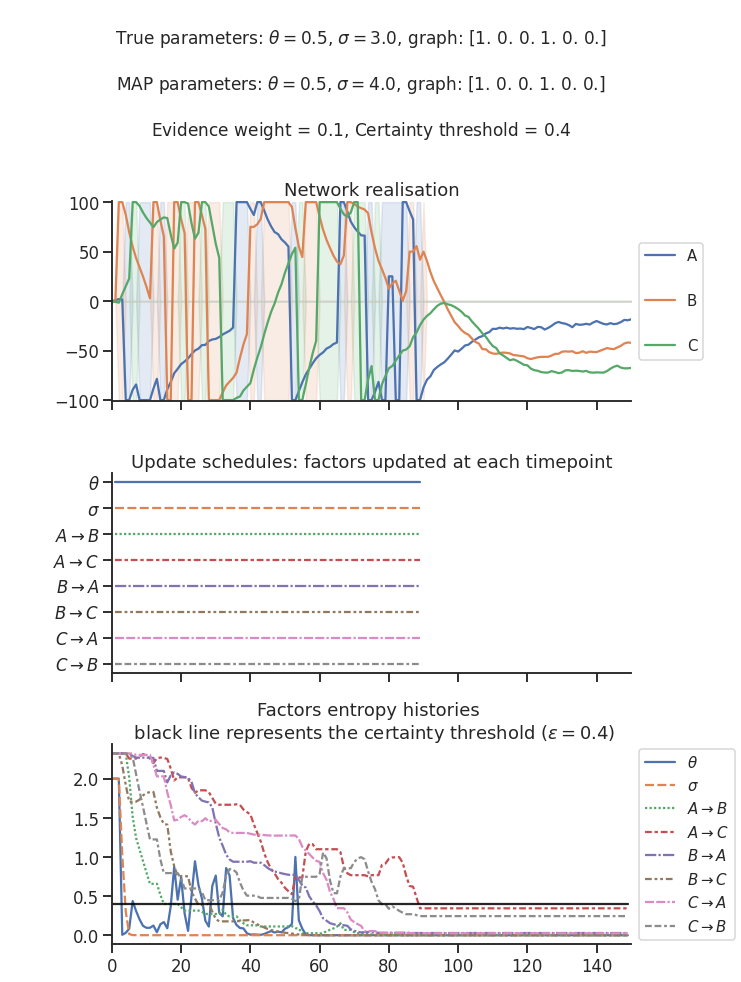

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

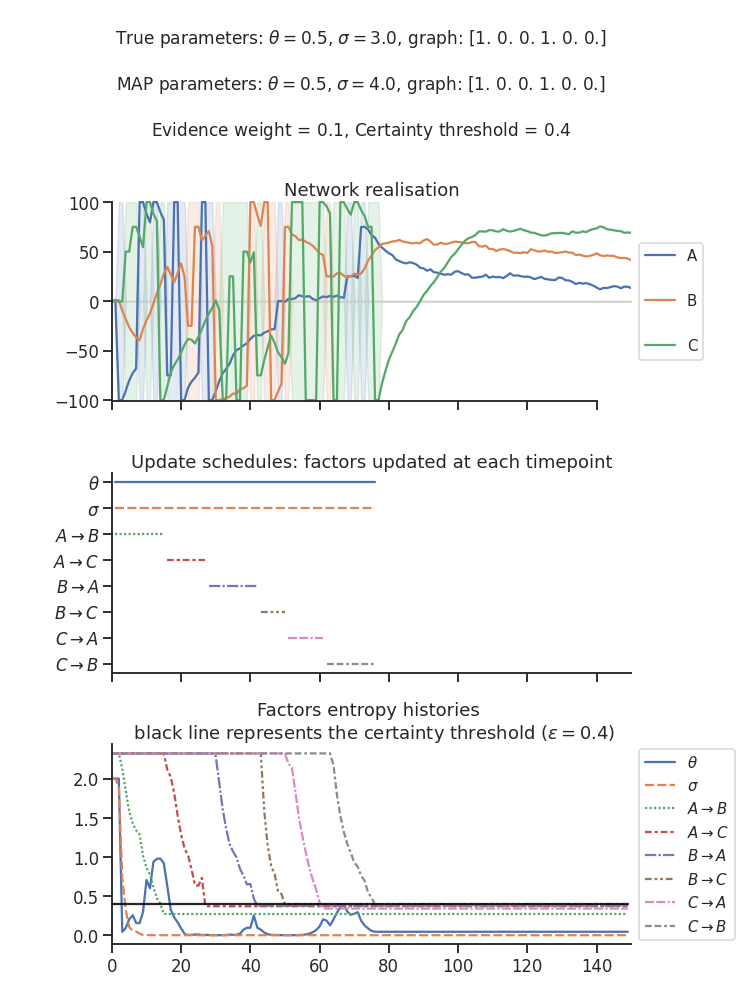

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

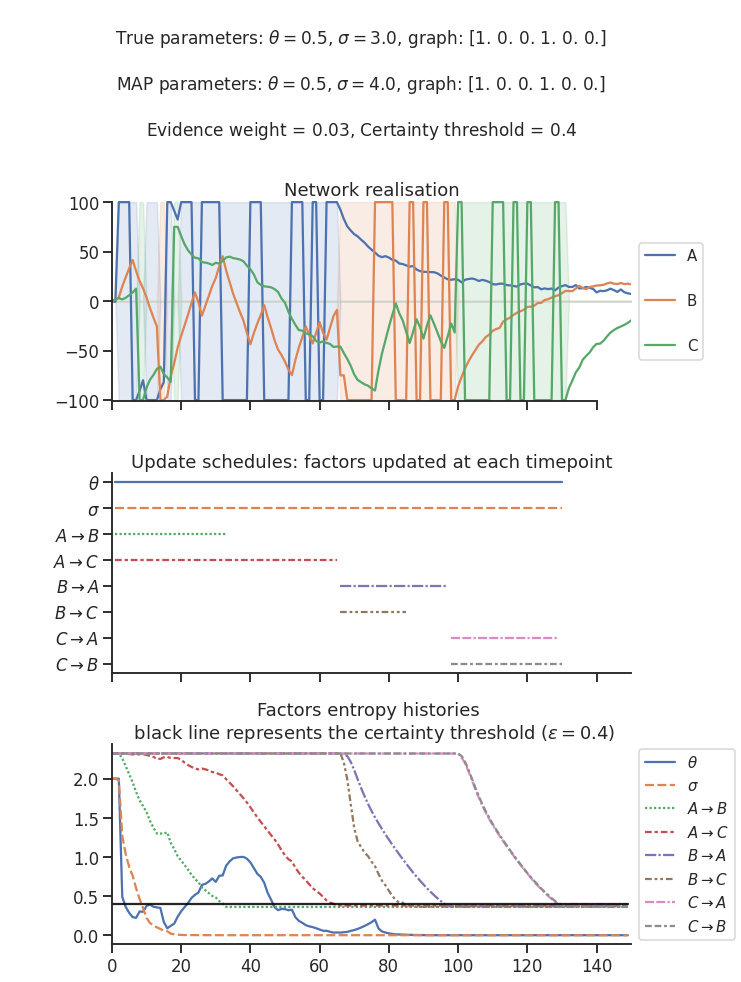

In [9]:
experiment.variational_report(labels=['A', 'B', 'C'])

<AxesSubplot:title={'center':' '}>

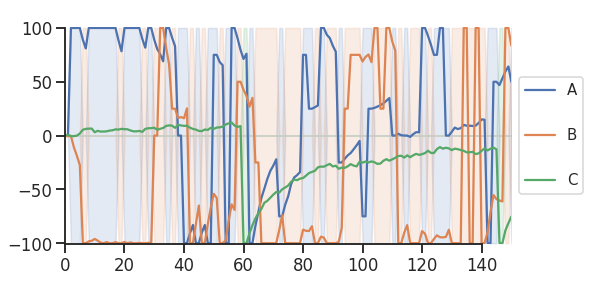

In [9]:
experiment.path_report(title=' ', labels=['A', 'B', 'C'])